## Statistical Hypothesis testing
In this note, I review the concept of statistical hypothesis testing. I also demonstrate A/B testing and the linear regression testing with NHIS dataset.

### Review: Statistical hypothesis testing

Statistical hypothesis testing is an inferential method to test the claim on the random variables representing the data. 
Hypothesis testing is paremteric or non-parametric depending on if there is any assumption on the distribution for the random variables or not. Since the parametric tests are often more powerful and widely used, I focus on parametric tests in this note.

Hypothesis testing starts with a **null hypothesis** about population parameter and the **significance level**, $\alpha$. With these,
* If $\text{Pr(Null hypothesis is true)}<\alpha$, the test rejects the null hypothesis.
* If $\text{Pr(Null hypothesis is true)}\ge\alpha$, the test remains inconclusive.

This probability of null hypothesis being true is called **p-value**. To be precise, it indicates the probability of observing current dataset or rarer dataset when the null hypothesis is true. Since the test gives statistically significant results only if the null hypothesis is rejeceted, the null hypothesis is constructed as the negation of the claim one wish to prove. $\alpha$ is set to be a small number such as 0.01 or 0.05 beforehand.

Hypothesis testing can have two types of errors:
* Type I error: Rejecting the null hypothesis when it is true (false postivie)
* Type II error: Not rejecting the null hypothesis when it is false (false negative)
From the definition of p-value, the probability of having type I error is equal to the significance level $\alpha$.

### Tests regarding population mean

While the hypothesis testing can test any claim on the population, population mean is the subject of test in many cases. Now I regard the dataset $x_1,\cdots,x_n$ as observed instances for random variables $X_1,\cdots,X_n$. When these random variables are repeated observations of the identical experimentation, these random variables are set to be independent and identically distributed, or iid in short. Then one can regard this data set as a sample of size $n$ chosen from a population of mean $\mu$ and variance $\sigma^2$. While one wishes to make claims about $\mu$, the sample mean $\bar{x}=(x_1+\cdots+x_n)/n$ is only accessible from the given dataset. This gap can be overcome with a theorem called the **central limit theorem (CLT)**:
$$\begin{eqnarray}
\textbf{CLT:}&& \text{when }X_1,\cdots,X_n \text{ are iid,} \\
&& \bar{X}=(X_1+\cdots+X_n)/n \sim N(\mu,\sigma/\sqrt{n})\text{ as }n\to\infty.
\end{eqnarray}$$
Here, $N(a,b)$ indicates the normal distribution of mean $a$ and variance $b^2$. Thanks to this theorem, one can approximate the distribution of $\bar{X}$ as a normal distribution for a large sample size. This is particularly useful since this builds the pretty well understood normal distrubition out of arbitrary underlying distribution of $X_i$. From this normally distributed $\bar{X}$, several useful quantities can be calculated:
* **p-value:** To calculate p-value from the data sample, some known distribution must be used. While the kinds of this distribution depends on the assumed distribution of $X_i$ and other parameters calculated from the data sample, CLT ensures that any of such distribution approaches to the normal distribution as the sample size grows. For example, one sample test to see if the mean is equal to a particular value $\mu_0$ for a nomrally distributied variable is tested with t-statsitic. In this particular case, t-statistic is given by
$$\begin{eqnarray}t=\frac{\bar{x}-\mu}{s/\sqrt{n}}\end{eqnarray}.$$
While the p-value can be calculated exactly by using t-distribution, a normal distribution can be used for approximate calculation when the sample size $n$ is large enough. This trick works even when $X_i$ is not following any known distribution, so this becomes a reason why one can apply hypothesis testing for large sample size, even when the assumption on underlying distribution is not precisely satisfied.
* **Confidence interval (CI):** With the given sample mean $\bar{x}$ and the sample variance $s^2$, an estimated range for $\mu$ can be calculated up to some confidence level $\gamma$, based on the normal distribution of $\bar{X}$. For $z^*$ such that $\Phi(z^*)=(1-\gamma/2)$, the confindence interval for $\mu$ is given by 
$$\begin{eqnarray}
\text{CI: } \left(\bar{x}-z^*\frac{s}{\sqrt{n}},\bar{x}+z^*\frac{s}{\sqrt{n}}\right). 
\end{eqnarray}$$

### Demonstration with NHIS dataset
For the rest of the note, I would demonstrate the two most common hypothesis tests, A/B testing and linear regression testing. I would use the dataset from National Health Interview Survey (NHIS) of year 2019 (www.cdc.gov/nchs/nhis/2019nhis.htm). While these data are collected with some sampling weights, I disregard the weights for the simplicity of analysis.

I first load the relevant libraries.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import statsmodels.formula.api as sf
import matplotlib.pyplot as plt

Then I load the dataset and filter with desired quantities. I also divide it into the dataset of male responders and the dataset of female responders. For exploration of data, I print out the summary of each dataset.

In [2]:
df_nhis=pd.read_csv("nhis2019.csv")
cols=["SEX_A","AGEP_A","WEIGHTLBTC_A","HEIGHTTC_A"]
col_names=["sex","age","weight","height"]

df=df_nhis[cols]
df=df[
    (df["SEX_A"]<3)&(df["AGEP_A"]<90)
    &(df["WEIGHTLBTC_A"]<300)&(df["HEIGHTTC_A"]<80)
]
df=df.rename(columns=dict(zip(cols,col_names)))
df["sex"]=df["sex"].replace({2:0})
df_male=df[df["sex"]==1]
df_female=df[df["sex"]==0]
print("Entire dataset:")
print(df.describe())
print("Dataset of male responders:")
print(df_male.describe())
print("Dataset of female responders:")
print(df_female.describe())

Entire dataset:
                sex           age        weight        height
count  29121.000000  29121.000000  29121.000000  29121.000000
mean       0.467772     52.092991    177.004052     66.775076
std        0.498969     18.295392     39.319784      3.888349
min        0.000000     18.000000    100.000000     59.000000
25%        0.000000     36.000000    148.000000     64.000000
50%        0.000000     53.000000    174.000000     67.000000
75%        1.000000     67.000000    200.000000     70.000000
max        1.000000     85.000000    299.000000     76.000000
Dataset of male responders:
           sex           age        weight        height
count  13622.0  13622.000000  13622.000000  13622.000000
mean       1.0     51.418367    194.447071     69.796726
std        0.0     17.931042     35.509748      2.821100
min        1.0     18.000000    126.000000     63.000000
25%        1.0     36.000000    170.000000     68.000000
50%        1.0     52.000000    190.000000     70.000000

### A/B testing
A/B testing, also called as split testing, compares the means of two independent dataset, A and B. It assumes that each dataset is drawn from iid random variables, possibly having different distribution between dataset A and B. This testing is often used when one tries to find out if particular treatment has an effect on the target variable, as well as it is possible to control other features equally for both of the dataset. In such cases, A and B become the control and treatment group.

While precise way to calculate the statistic depends on the assumed population distributions. For continuous data, normal distribution is often assumed, and t-statistic is used accordingly. While the standard two-sample t-test assumes that two distribution has eqaul variance, one can use Welch's t-test instead without assuming the equal variance.

From NHIS dataset, I would test if the mean weight differs in the male responders and the female responders. First, I plot the histograms and means for each dataset. 

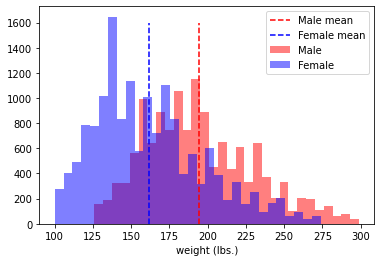

In [3]:
plt.figure()
mean_male=df_male["weight"].mean()
mean_female=df_female["weight"].mean()
plt.plot([mean_male,mean_male],[0,1600],"--",color="r")
plt.plot([mean_female,mean_female],[0,1600],"--",color="b")
plt.hist(df_male["weight"],bins=30,color="r",alpha=0.5)
plt.hist(df_female["weight"],bins=30,color="b",alpha=0.5)
plt.xlabel("weight (lbs.)")
plt.legend(["Male mean","Female mean","Male","Female"]);

While it seems the male responders have higher weigh on average, we can test if this is true statistically. I run t-test with scipy.stats.

In [9]:
t_statistic,p_value=ttest_ind(df_male["weight"], df_female["weight"], equal_var=True)
print("t-statistic:",t_statistic)
print("p-value:",p_value)

t-statistic: 78.0394898231133
p-value: 0.0


The test result yields a huge t-statistic, and the corresponding p-value becomes very small so that it is even smaller than the double precision. This is because both datasets have large sample sizes. To see how these numbers change with sample sizes, I repeat the same calculation for much smaller sizes of samples.

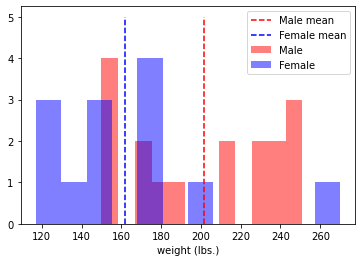

t-statistic: 2.763307427048691
p-value: 0.009998922422674961


In [5]:
df_mini=df.sample(30,random_state=0)
df_mini_male=df_mini[df_mini["sex"]==1]
df_mini_female=df_mini[df_mini["sex"]==0]

plt.figure()
mean_male=df_mini_male["weight"].mean()
mean_female=df_mini_female["weight"].mean()
plt.plot([mean_male,mean_male],[0,5],"--",color="r")
plt.plot([mean_female,mean_female],[0,5],"--",color="b")
plt.hist(df_mini_male["weight"],bins=12,color="r",alpha=0.5)
plt.hist(df_mini_female["weight"],bins=12,color="b",alpha=0.5)
plt.xlabel("weight (lbs.)")
plt.legend(["Male mean","Female mean","Male","Female"])
plt.show()

t_statistic,p_value=ttest_ind(df_mini_male["weight"], df_mini_female["weight"], equal_var=True)
print("t-statistic:",t_statistic)
print("p-value:",p_value)

Compared to previous calculations, t-statistic got much smaller and p-value becomes a visible number (~1%). With $\alpha=0.05$, this AB testing still states that male responders have significantly higher weights than female responders.

### Linear regression testing

Instead of splitting the dataset into two, I may include the encoding of male (1) and female (0) responder as the data. Then I perform linear regression and see if the coefficient for this new variable is significantly different from 0. So now I run linear regression with statsmodel library:

In [6]:
print(sf.ols("weight ~ sex",df_mini).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     7.636
Date:                Fri, 29 Jan 2021   Prob (F-statistic):             0.0100
Time:                        20:26:19   Log-Likelihood:                -151.60
No. Observations:                  30   AIC:                             307.2
Df Residuals:                      28   BIC:                             310.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.8462     10.875     14.883      0.0

As seen in the result, t-statistic and p-value for the coefficient of "sex" variable are exactly equal to the previous calculation. Why? This is because the null hypotheses of both tests are equal, and therfore they are essentially same hypothesis testing; if the coefficient is zero, the male dataset and the female dataset have equal mean. If the coefficient is non-zero, they don't.

While A/B testing requires the two samples need to be controlled exactly the same for all the other variables than the treated variable, the linear regression testing can be used even when the two samples are not controlled equally. For example, suppose we did not control the feature "age" and "height" equally in the male dataset and the female dataset. Now I run the linear regression including these variables:

In [7]:
print(sf.ols("weight ~ sex + age + height",df_mini).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     4.721
Date:                Fri, 29 Jan 2021   Prob (F-statistic):            0.00926
Time:                        20:28:47   Log-Likelihood:                -148.70
No. Observations:                  30   AIC:                             305.4
Df Residuals:                      26   BIC:                             311.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -184.4961    148.748     -1.240      0.2

Now the t-statistic and p-value of coefficient for "sex" variable are no longer same as before. This is because this coefficient means different thing from previous cases. It now means the difference of weight due to the sex, provided that the age and height are equally set. While the t-statistic is still positive, it is not large enough so that p-value is greater than 0.05. Now I cannot reject the null hypothesis, and cannot state if the male responder has significantly higher weight than female responder with same age and height.